<a href="https://colab.research.google.com/github/yhussain1/MachineLearning/blob/main/Copy_of_FPLCluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering with the FPL Dataset

We will be using the Fantasy Premier League dataset for exploratory data analysis, represent it through visualisations and machine learning. The FPL dataset consists of player data scraped from the fantasy premier league website using UiPath, which scores player performance throughout the season with points. Users of the  website can create teams of these players and compete with other players to see how well their player team choices performed. These statistics are freely obtainable from the website.

The data contains 5 columns `Player, Cost, Sel., Form and Pts.`
* `Player` - Contains the players name, position and team they play for.
* `Cost` - The cost for users to purchase the player for their team.
* `Sel.` - Percentage of the total teams that have added the player in their teamas of the last game week.
* `Form` - How well the player has been performing. Its averaged over all matches played within the last 30days.
* `Pts.` - The total number of points accumulated by the player since the start of the current season.

Our goal with this dataset will be to assess how user choice is affected by the player stats and if a model can be use to predict user behaviour from the present data.

In [23]:
#@title Imports and Read CSV
#import packages required
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from scipy import stats
from sklearn.metrics import confusion_matrix


sns.set(rc={'figure.figsize':(15,10)})
# Loading the csv file, we don't split it as we are clustering
# Sel. column is stored as percentage so converted to decimal values

fpl = pd.read_csv("fpl.csv", delimiter = ',')
fpl['Sel.'] = (fpl['Sel.'].str.rstrip('%').astype('float')/100).apply(lambda y: round(y,3))

#Feature Correlation

Firstly, a ***heatmap*** is generated to see how strong the correlation between the columns are.
A strong correlation is seen between *Total Points* and *Selection*.

Another but less strong correlation is between *Total Points* and *Form* so upto 3 dimensions can possibly be explored.

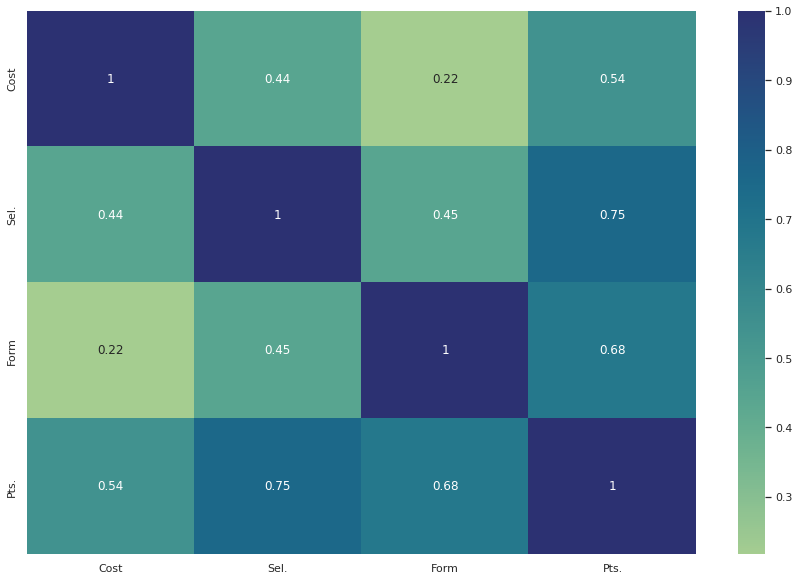

In [24]:
sns.heatmap(fpl.corr(), annot=True, cmap="crest")
plt.show()

#Data Visualisation

It is also possible to explore and understand the entire dataset through visualisations. In this case we can use different mwthods within the scattergrapgh from the seaborn package to represent more than 4 dimensions.

Generally, most data points are within the bottom left which is understandable as underperforming players are less likely to be chosen when players with better point scores can be chosen.

As seen in the the scattergraph the general positive trand is more obvious and players with a greater *Total Point* score are generally more likely to be selected into teams. There is an obvious outlier in this 

Furthermore, the size of the datapoint can describe the form of the player. Even with poor form a player may be kept in a large selection of teams. This can be due to the next factor which is *Price* which seems to play a part in *Selection*.

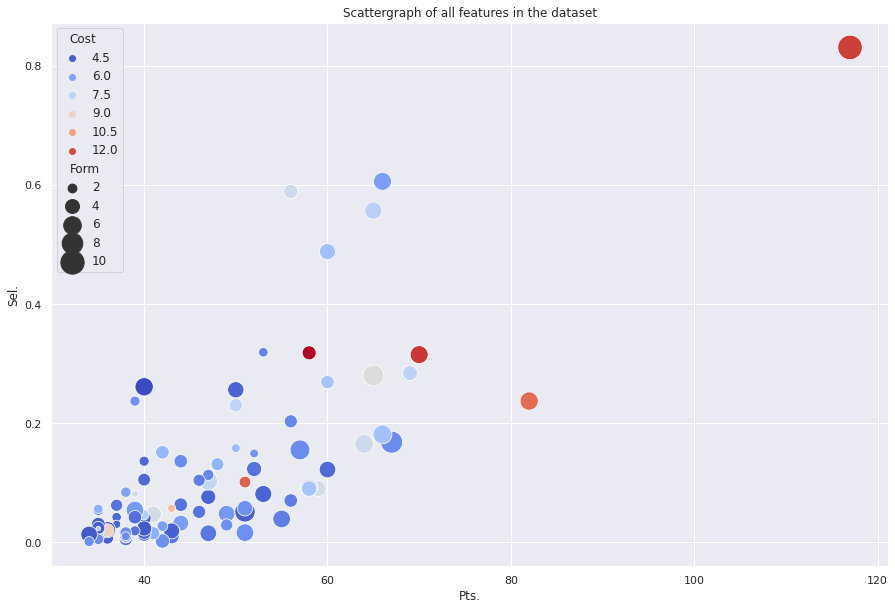

In [25]:
x = fpl['Pts.']
y = fpl['Sel.']
no_x = fpl['Cost']
no_y = fpl['Form']
sns.scatterplot (x, y, size=no_y, sizes=(20,600), hue=no_x, 
                 palette='coolwarm').set(title="Scattergraph of all features in the dataset")
plt.show()

#Further Visualisation of the Correlations

Now that we have a understanding of the data and an idea of how features of the dataset relate to eachother, its time to decide the features to use for our classification and regression models. 

As shown below and from referencing the ***Correlation Heatmap***, a good correlation to explore is between *Selection* and *Total Points*. It is worth mentioning further dimensions can be explored with the form feature in addition to these.

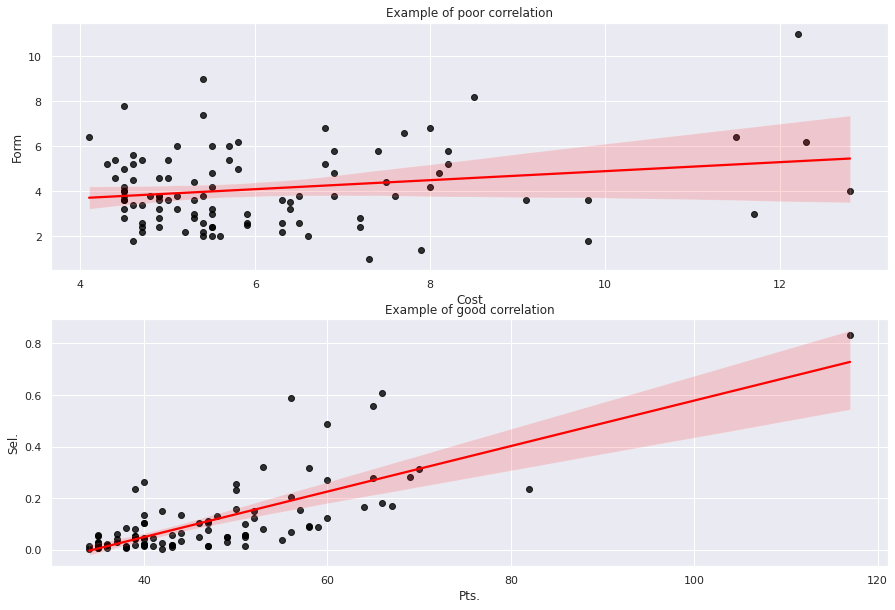

In [26]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,10))
sns.regplot (x, y, ax=ax2, scatter_kws={"color": "black"}, 
             line_kws={"color": "red"}).set(title="Example of good correlation")
sns.regplot (no_x, no_y, ax=ax1, scatter_kws={"color": "black"}, 
             line_kws={"color": "red"}).set(title="Example of poor correlation")
plt.show()

# Outliers
As seen by the Scattergraph there are obvious outliers in comparison to the rest of the dataset. This is further represented by the produced boxplot.

The boxplot is very useful in this representation as it can tell you about the values of outliers, how symmetrical the data is and how well grouped it is. A skew also becomes more obvious. We have our:
* Outliers, 
* Minimum, 
* Maximum, 
* 25th%tile, 
* 75th%tile

Which encompass the IQR and the Median.

The most glaring issue with this dataset is how poorly spread the IQR is. The IQR contains the bulk of the data and its variability. A larger variability is preferred to acquire more meaningful results. Some form of data cleaning is needed here to make the data more consistent and easier for our algorithms to use. 

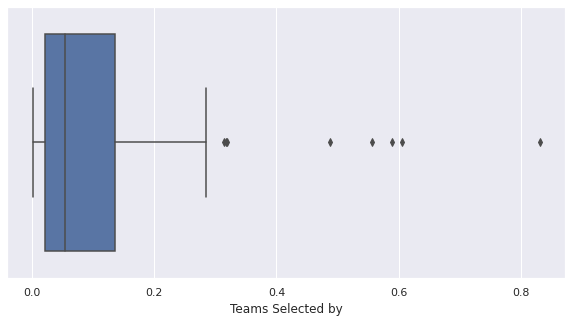

In [27]:
# Understand the outliers present in the current data set for the Sel. column
#fpl.boxplot('Sel.')

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(y, ax=ax)
plt.xlabel('Teams Selected by')
plt.show()

#Data Cleaning
The below code is used to remove the outliers and keep the data more consistent with the current quartile ranges.

As shown by the adjusted boxplot a much greater variance of the data is available within the quartile ranges. There are still outliers however with more consistent data it will now work much better with our algorithms.

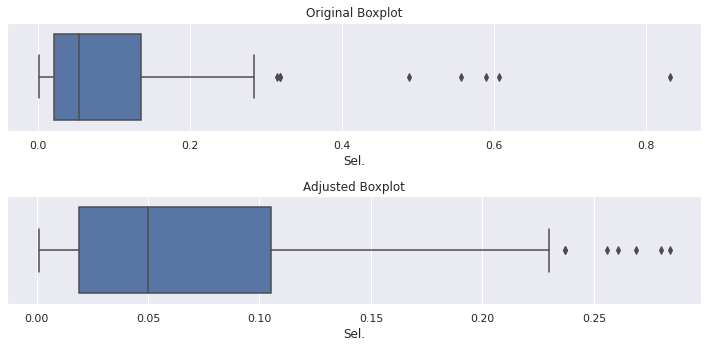

In [28]:

fpl1 = fpl.copy()

for i in ['Sel.']:
    q75,q25 = np.percentile(fpl.loc[:,i],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    fpl.loc[fpl[i] < min,i] = np.nan
    fpl.loc[fpl[i] > max,i] = np.nan
  
fpl.isnull().sum()
fpl = fpl.dropna(axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
sns.boxplot(fpl['Sel.'], ax=ax2).set(title="Adjusted Boxplot")
sns.boxplot(fpl1['Sel.'], ax=ax1).set(title="Original Boxplot")
fig.tight_layout()
plt.show()

#Pre-Clustering
Before performing the ***KMeans Clustering*** we need to identify the ideal number of clusters to use for our data. A method to idenfity this is the ***Elbow Method***.

This method calculates the sum of squared distances from each point to its assigned centroid for each iteration of KMeans. It will then run through a different number of clusters. Through this we achieve a line chart that displays the sum of squared distances at each cluster. The most ideal number of clusters will be the one closest to the elbow of the line chart. Another preference to add to this decision would be the lower sum of squres distance (Inertia). The lower the sum of squares distances means the data inside each cluster are more tightly grouped.

The plot created below shows the elbow is around 2 or 3 so in this scenario 3 would be a good number of clusters to choose for this.

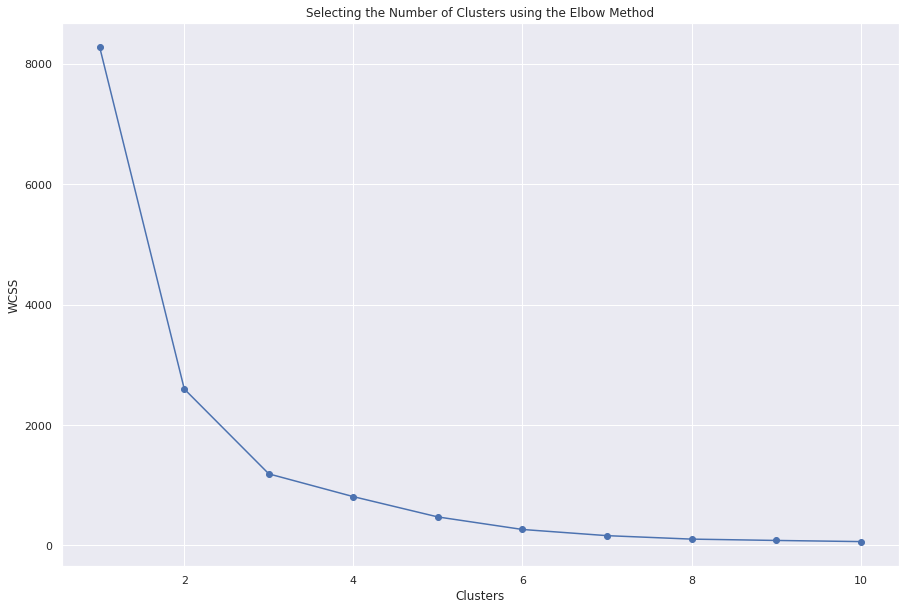

In [29]:
data = fpl[['Sel.', 'Pts.']].copy()

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(data)

wcss=[]

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(data)
  wcss.append(kmeans.inertia_)

sns.set()
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Selecting the Number of Clusters using the Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS') # within cluster sum of square
plt.show()

# plot shows the elbow between 2 and 3, 3 clusters were chosen

# KMeans Clustering

***KMeans Clustering*** is an unsupervised machine learning algorithm. Usupervised meaning it makes inferences from datasets using only input vectors without referring to known, or labelled outcomes.

The objective of KMeans is to group similar data points together and discover underlying patterns. It does this by looking for a fixed number of clusters in the dataset.

So we will use the KMeans algorithm to uncover meaningful groups in the data. In this case we will try to identify how team selection is affected by the total points of a player.

3 clusters will be used with a random state assigned to give the data a fixed state when choosing data points.

From the graph below the algorithm successfully identifies the 3 clusters. It is important to note we are here to explore the data and as the individual datapoints do not have any tags there are no tags to measure the the accuracy against. Even then we can make interpretations of the clusters.

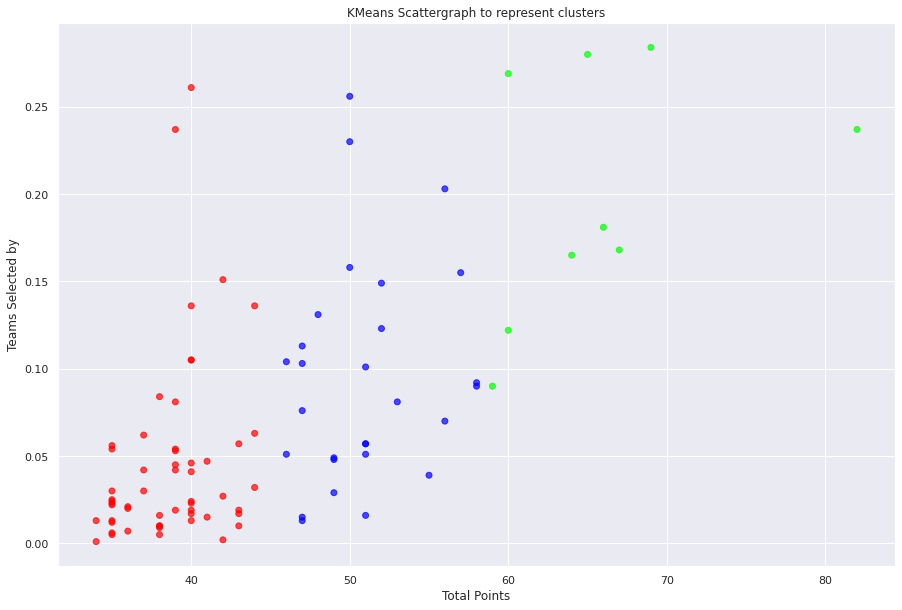

In [30]:
# data is put through the kmeans algorithm choosing a fixed state
# scattergraph used to represent the clusters of the data
# x is teams selected by and y is total points accumulated

x = fpl['Pts.']
y = fpl['Sel.']


kmeans = KMeans(init='random', n_clusters=3, random_state=2)
kmeans.fit(data)
labels=kmeans.labels_

plt.scatter(x,y, c=labels, cmap='brg', alpha=0.7)
plt.title("KMeans Scattergraph to represent clusters")
plt.xlabel('Total Points')
plt.ylabel('Teams Selected by')

plt.show()



#3D Visualisation
As mentioned previously we can also add onto this visualisation with a 3rd dimension. In this case, we will add *Form* as another column by which we can explore the clusters present. Again, a elbow graph is produced to identify the ideal number of clusters. Same as before, 3 looks to be a suitable amount.

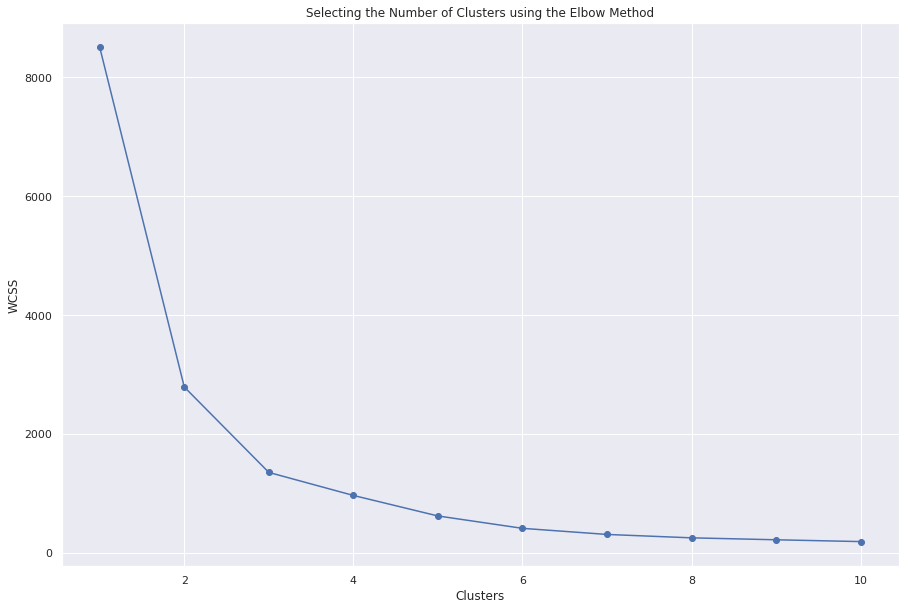

In [31]:

data1 = fpl[['Pts.', 'Sel.', 'Form']].copy()

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(data1)

wcss1=[]

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(data1)
  wcss1.append(kmeans.inertia_)

sns.set()
plt.plot(range(1, 11), wcss1, marker='o')
plt.title('Selecting the Number of Clusters using the Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

# a decision between 2 and 3 so 3 is chosen

Adding the *Form* feature further differentiates the groups and gives us a better idea of how the ***KMeans*** has worked to split the data. 

The attributes for each datapoint can be thought of as the data points value as an asset for the user of the website. In this case from the 3d graph Red are high valued, Blue are medium valued and Yellow are low valued.

It is worth mentioning both ***plotly*** and ***matplotlib*** were used to attempt these. The visualisations show plotly is more accessible to easily view the data through different angles whereas ***matplotlib*** does not provide this functionality as easily.

Text(0.5, 0, 'Player Form')

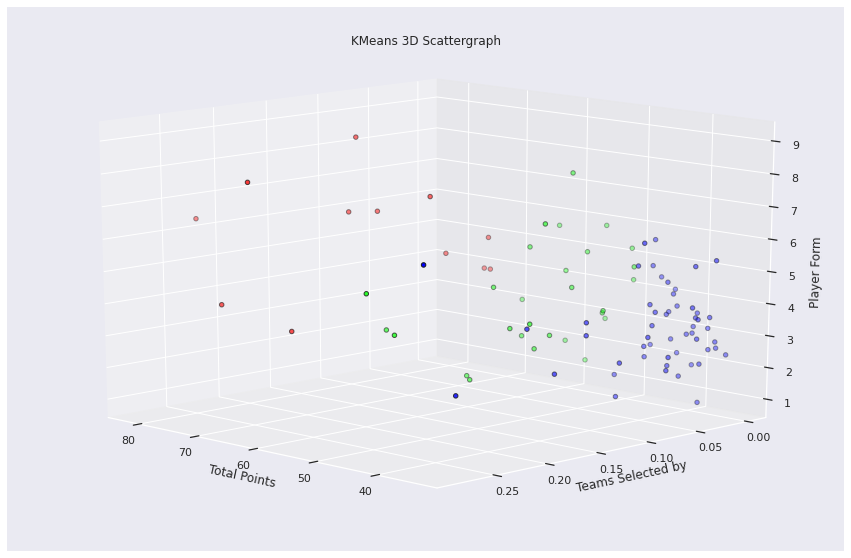

In [32]:
# plotly 3d model
kmeans1 = KMeans(n_clusters=3)
kmeans1.fit(data1)
labels1 = kmeans1.labels_

Scene = dict(xaxis = dict(title  = 'Total Points'),
             yaxis = dict(title  = 'Teams Selected by'),
             zaxis = dict(title  = 'Player Form'))

trace = go.Scatter3d(x=data1['Pts.'], y=data1['Sel.'], z=data1['Form'], mode='markers', 
                     marker=dict(color=labels, size=10, line=dict(color='black', width=10)))

layout = go.Layout(margin=dict(l=0,r=0), scene = Scene, height = 600,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

fig = plt.figure()
subfigure = fig.add_subplot(111, projection="3d", elev=15, azim=135)
subfigure.scatter(data1['Pts.'], data1['Sel.'], data1['Form'], 
                  c=labels1.astype(float), cmap='brg', 
                  edgecolor="k")
subfigure.set_title('KMeans 3D Scattergraph')
subfigure.set_xlabel('Total Points')
subfigure.set_ylabel('Teams Selected by')
subfigure.set_zlabel('Player Form')

# producing a 3d representation of the kmeans cluster

#Spectral Clustering
KMeans is a good data algorithm especially for finding groups where cluster members are close to eachother (in a Eauclidean sense).

An alternative is ***Spectral Clustering*** which is more general and powerful than KMeans. ***Spectral Clustering*** technique is based on graph theory which identifies a community of nodes in a graph based on edges connecting them. It can also be used to cluster non graph data as well.

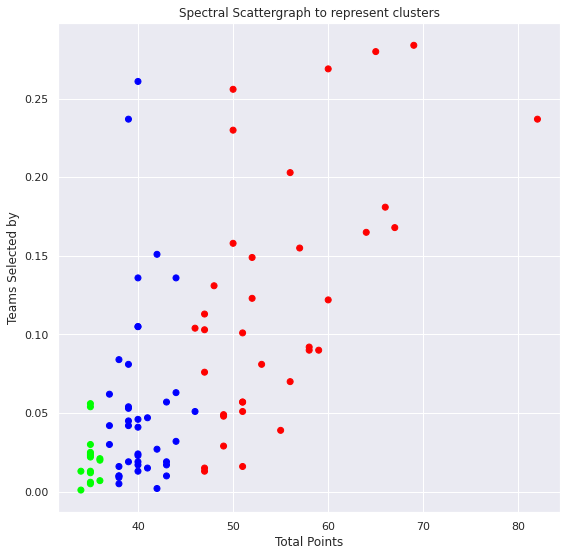

In [33]:
#spectral clustering
data2 = fpl[['Sel.', 'Pts.']].copy()

sc_nn = SpectralClustering(n_clusters=3, affinity ='nearest_neighbors', random_state=0)
sc_nn.fit(data2) 

plt.figure(figsize =(9, 9))
plt.scatter(data2['Pts.'], data2['Sel.'], c=sc_nn.labels_, cmap='brg')
plt.title("Spectral Scattergraph to represent clusters")
plt.xlabel('Total Points')
plt.ylabel('Teams Selected by')

plt.show()

We can also test ***Spectral Clustering*** for multiple points of clusters to see how the clustering algorithm identifies the groups.
Possible convergence errors due duplicate points in the *Total Points*.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



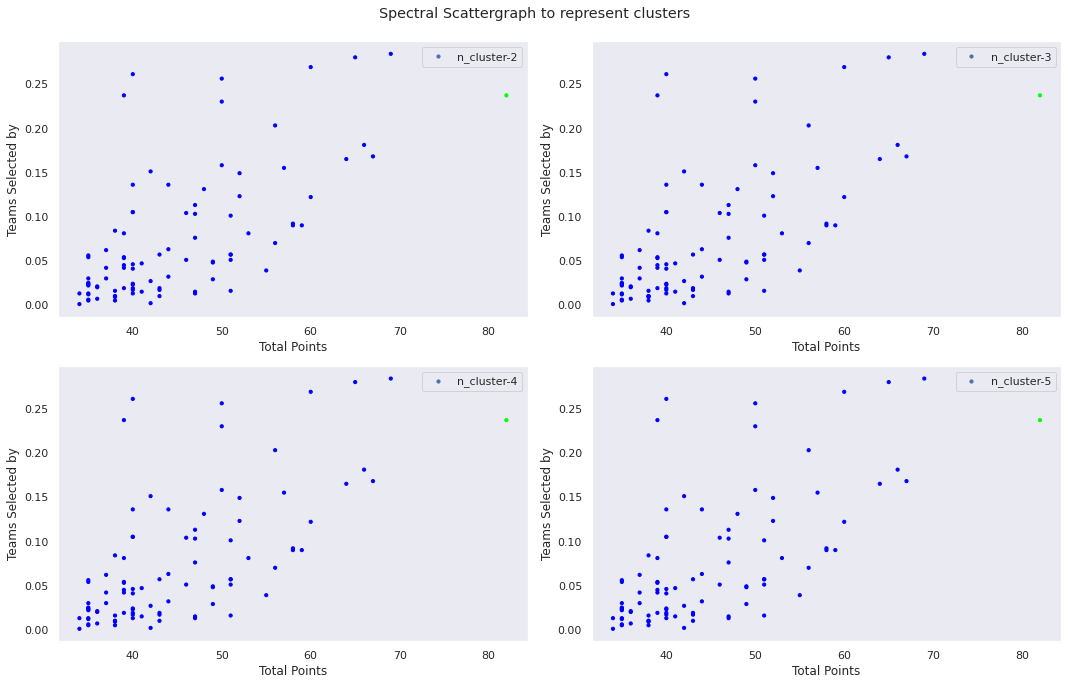

In [34]:
# multiple clusters for spectral clusters
f = plt.figure()
f.add_subplot(2, 2, 1)
f.suptitle("Spectral Scattergraph to represent clusters")

for i in range(2, 6):
  datam = fpl[['Sel.', 'Pts.']].copy()
  sc = SpectralClustering(n_clusters=i, random_state=80)
  sc = sc.fit(datam)
  f.add_subplot(2, 2, i-1)
  plt.scatter(data2['Pts.'], data2['Sel.'], s=10, c=sc.labels_, label="n_cluster-"+str(i), cmap='brg')
  plt.xlabel('Total Points')
  plt.ylabel('Teams Selected by')
  plt.grid(False)
  plt.legend()

f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Affinity Propagation
Affinity Propagation is another unsupervised clustering method. It does not require us to specify the number of clusters.

It works by each data point sending messages to all other datapoints informing its targets of each targets relative attractiveness to the sender. Messages are then continuously sent until a consensus of each targets relative attractiveness to the sender is.

~~As seen by the graph produced, no consensus was reached so no clusters were formed. Not all clustering algorithms will produce expected results so this was left as a n example of one which does not deal well with this dataset.~~

5 Clusters identified.

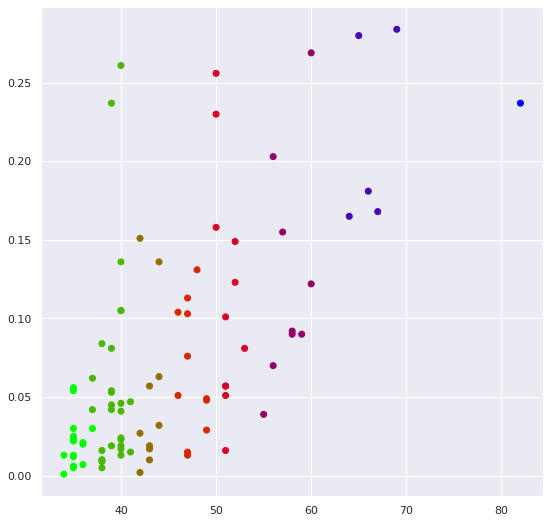

In [35]:
# affinity propagation
data3 = fpl[['Sel.', 'Pts.']].copy()

ap = AffinityPropagation()
ap.fit(data3)

plt.figure(figsize =(9, 9))
plt.scatter(data3['Pts.'], data3['Sel.'], c=ap.labels_, cmap='brg')

plt.show()

#Linear Regression
***Regression*** is used to search for relationships between variables. An assumption is made for the dependant and independant variables. 

***Linear Regression*** calculates the predicted weights of the regression coefficients. These predicted values are normally expected to be as close as possible to the actual response and the difference between the two are called residuals. The focus with regression is on the the best predicted weights or smallest residuals.

***Reshaping*** used here so machine learning algorithm can work on the data by changing the shape of an array. And the shape of an array is determined by the number of elements in each dimension. Reshaping allows us to add or remove dimensions in an array.

In [36]:
# machine learning linear regression

X = fpl['Pts.'].values.reshape(-1,1)
y = fpl['Sel.'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)


y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()


,Actual,Predicted
0,0.168,0.192214
1,0.113,0.087068
2,0.101,0.108097
3,0.149,0.113354
4,0.070,0.134384


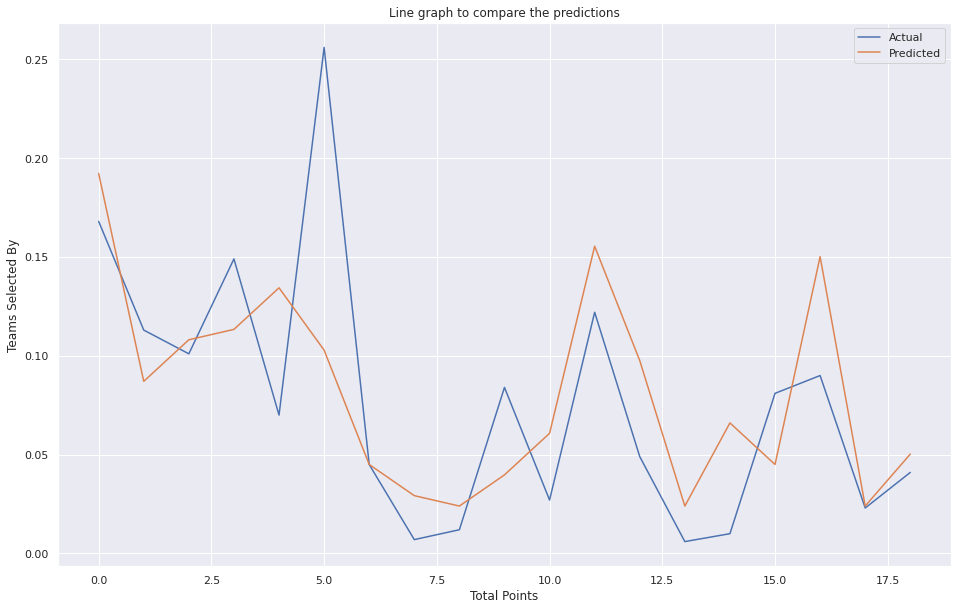

In [37]:
# visualise the different scores
df1 = df.head(25)
df1.plot(kind = 'line', figsize=(16,10))
plt.title('Line graph to compare the predictions')
plt.xlabel('Total Points')
plt.ylabel('Teams Selected By')
plt.show()

In [38]:
def predictval(x):
  slope = regressor.coef_
  intercept = regressor.intercept_
  result = (slope*x + intercept)*100
  pick = (result[0])
  return (str(round(pick[0],2))+'%')

predictval(40)

'5.03%'

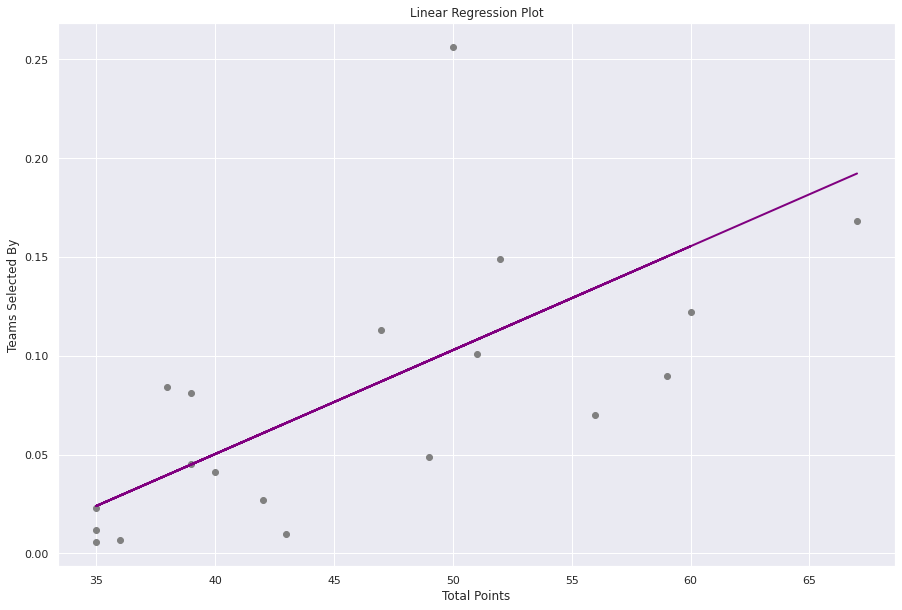

In [39]:
plt.scatter(X_test, y_test, color='gray')
plt.plot(X_test, y_pred, color='purple', linewidth=2)
plt.title('Linear Regression Plot')
plt.xlabel('Total Points')
plt.ylabel('Teams Selected By')
plt.show()

In [40]:
# algorithm performance
lrMAE = metrics.mean_absolute_error(y_test, y_pred)
lrMSE = metrics.mean_squared_error(y_test, y_pred)
lrRMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(regressor.intercept_)
print(regressor.coef_)

[-0.16002638]
[[0.00525732]]


# Polynomial Regression
Polynomial Regression is a form of Linear Regression

In [41]:
# polynomial regression
X = fpl['Pts.'].values.reshape(-1,1)
y = fpl['Sel.'].values.reshape(-1,1)

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=0)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)
poly_reg_y_predicted = poly_reg_model.predict(X_test)

df2 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': poly_reg_y_predicted.flatten()})
df2.head()

,Actual,Predicted
0,0.168,0.212505
1,0.113,0.077520
2,0.101,0.102299
3,0.149,0.108993
4,0.070,0.136982


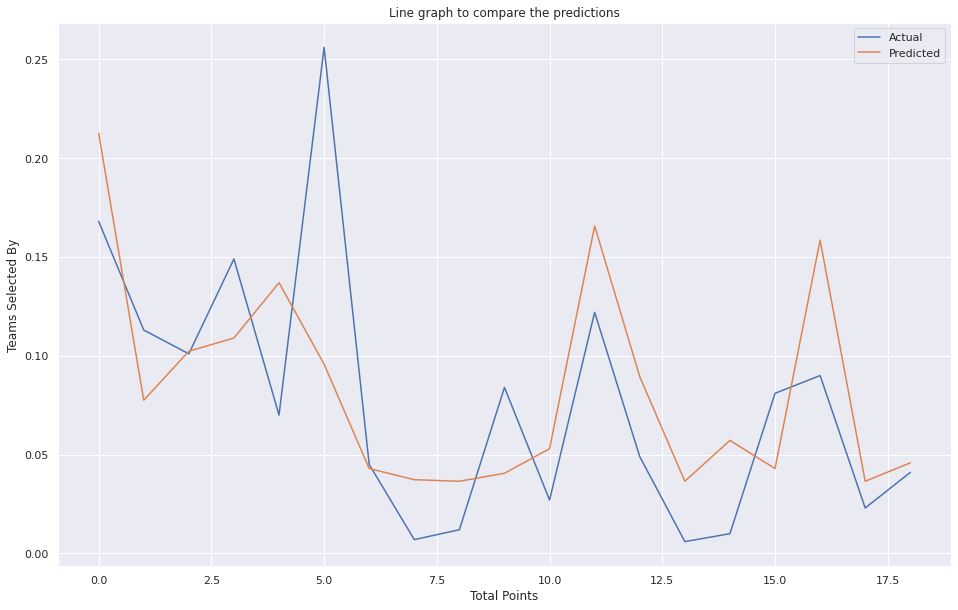

In [42]:
df3 = df2.head(25)
df2.plot(kind = 'line', figsize=(16,10))
plt.title('Line graph to compare the predictions')
plt.xlabel('Total Points')
plt.ylabel('Teams Selected By')
plt.show()

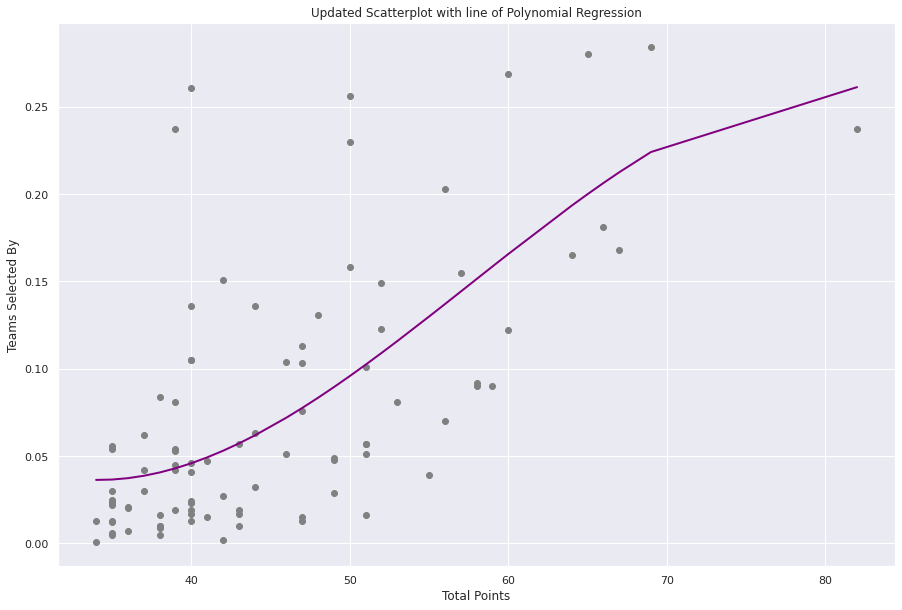

Linear Regression Mean Absolute Error: 0.036057621812371175
Linear Regression Mean Squared Error: 0.0024137529734610565
Linear Regression Root Mean Squared Error: 0.04912996003927803
Polynomial Regression Mean Absolute Error: 0.040082102925766944
Polynomial Regression Mean Squared Error: 0.0027439923380162233
Polynomial Regression Root Mean Squared Error: 0.05238313028080914


In [43]:
plt.scatter(X, y, color='gray')
plt.plot(X, poly_reg_model.predict(poly.fit_transform(X)), color='purple', linewidth=2)
plt.title('Updated Scatterplot with line of Polynomial Regression')
plt.xlabel('Total Points')
plt.ylabel('Teams Selected By')
plt.show()

# Linear Regression

print('Linear Regression Mean Absolute Error:', lrMAE)  
# Average absolute different between the predicted and actual value, average error

print('Linear Regression Mean Squared Error:', lrMSE)  
# Average squared difference between the predicted and actual value

print('Linear Regression Root Mean Squared Error:', lrRMSE)
# The square root of value obtained from the mean square error function, error rate

# Linear Regression with Polynomial Features

print('Polynomial Regression Mean Absolute Error:', metrics.mean_absolute_error(y_test, poly_reg_y_predicted))  
# Average absolute different between the predicted and actual value, average error

print('Polynomial Regression Mean Squared Error:', metrics.mean_squared_error(y_test, poly_reg_y_predicted))  
# Average squared difference between the predicted and actual value

print('Polynomial Regression Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, poly_reg_y_predicted)))
# The square root of value obtained from the mean square error function, error rate

# Measuring Accuracy
The MSE, MAE, RMSE, and R-Squared are mainly used metrics to evaluate the prediction error rates and model performance in regression analysis.

* MAE (Mean absolute error) represents the difference between the original and predicted values extracted by averaged the absolute difference over the data set.
* MSE (Mean Squared Error) represents the difference between the original and predicted values extracted by squared the average difference over the data set.
* RMSE (Root Mean Squared Error) is the error rate by the square root of MSE.
* R-squared (Coefficient of determination) represents the coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is.

In [44]:
def predictvalpol(x):
  result = poly_reg_model.predict(poly.fit_transform([[x]]))
  pick = (result[0]*100)
  return (str(round(pick[0],2))+'%')

print("Linear Regression Prediction: " + predictval(40)) # linear regression
print("Polynomial Regression Prediction: " + predictvalpol(40)) # polynomial regression
print("Linear Regression Prediction: " + predictval(30))
print("Polynomial Regression Prediction: " + predictvalpol(30))

Linear Regression Prediction: 5.03%
Polynomial Regression Prediction: 4.59%
Linear Regression Prediction: -0.23%
Polynomial Regression Prediction: 4.2%


# Future Plans

For the future with using this data I would like to further explore how the machine changes as the data gets updated throughout the game season as well as what the final results would look like in comparison to predicted values.